<a href="https://colab.research.google.com/github/BenjaminMoreau2000/phsx815_week-9-/blob/main/HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Benjamin Moreau
## PHSX 815 Project
## Neural Networks with Keras
### Can we predict the quality of wine based on its physical characteristics?
#### (March 15th, 2021)

This file downloads the `wine_quality` dataset from Tensorflow (the Keras backend); trains a neural network; uses it to predict wine quality.

In [2]:
#@title GPU Connector
#Run this particularly in Google colab to borrow a 4000$ GPU
!nvidia-smi -L
executeCell = True #Have to put this here because google colab...

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
#@title Google Drive Connector

#This is not needed but I included it anyway.
from google.colab import drive
drive.mount('/content/gdrive')
executeCell = True

Mounted at /content/gdrive


#Imports

In [4]:
#Import the dataset from tensorflow, for training and validation.

#create a tracker for which cells have run
#Cell order: 1
try:
  cell_tracker[0]=1
except:
  cell_tracker=[1,0,0,0,0,0,0,0,0,0,0,0,0]

#installs:
"""
!pip install tensorflow
!pip install numpy
!pip install pympler
#install the others if it still doesnt work but it should cuz colab is good...ish
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.activations import relu
import tensorflow_datasets as tfds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #Dont know what this does but if you remove the code breaks



import sys

import math
import struct
import csv
!pip install pympler
from pympler.asizeof import asizeof

import struct
import array
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 11.0 MB/s eta 0:00:00


#Load the data

In [5]:
#Cell order: 2
try:
  if(cell_tracker[0]==1):
    cell_tracker[1]=2
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif


#Load in the training data as a tensorflow dataset
#To get it as a numpy array, you can use tfds.as_numpy(*dataset*) to convert
#as_supervised=True argument loads the data as tuples i think
#It seems to be a dictionary object tho...

data_train = tfds.load('wine_quality',split='train',as_supervised=True)
#Split into red and white wines:
#tf.Tensors
data_train_white = tfds.load('wine_quality/white',split='train')
data_train_red = tfds.load('wine_quality/red',split='train')
print("\n *thumbs up*") #indicate that the cell finished

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/4898 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/wine_quality/white/incomplete.41JM1T_1.0.0/wine_quality-train.tfrecord*...…

Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/white/1.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1599 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/wine_quality/red/incomplete.W0NGU6_1.0.0/wine_quality-train.tfrecord*...: …

Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/red/1.0.0. Subsequent calls will reuse this data.

 *thumbs up*


#Diagnostic cells (Only run these for debug purposes)

In [6]:
print(data_train)#show the data object array
print(asizeof(data_train))#show the bit size of the dataset (its huge)

#if you want to peek at an example point

print("\n *thumbs up*")

<_PrefetchDataset element_spec=({'alcohol': TensorSpec(shape=(), dtype=tf.float32, name=None), 'chlorides': TensorSpec(shape=(), dtype=tf.float32, name=None), 'citric acid': TensorSpec(shape=(), dtype=tf.float32, name=None), 'density': TensorSpec(shape=(), dtype=tf.float32, name=None), 'fixed acidity': TensorSpec(shape=(), dtype=tf.float32, name=None), 'free sulfur dioxide': TensorSpec(shape=(), dtype=tf.float32, name=None), 'pH': TensorSpec(shape=(), dtype=tf.float32, name=None), 'residual sugar': TensorSpec(shape=(), dtype=tf.float32, name=None), 'sulphates': TensorSpec(shape=(), dtype=tf.float64, name=None), 'total sulfur dioxide': TensorSpec(shape=(), dtype=tf.float32, name=None), 'volatile acidity': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>
79744

 *thumbs up*


In [7]:
#look at an element (tuple)
for e in data_train:
  print("\nElement 0:",e,"\n")
  print(np.shape(e),np.shape(data_train))
  print(e[0])
  print()
  print(e[1])
  break
#Use take to get an object element
pt = data_train.take(1)
print("\nUsing <take()>: ",pt)

# type(pt)

#converting to numpy arrays makes things easier to work with
print("\nFeatures and label example:")
for features, label in tfds.as_numpy(pt):
    print(features,label)


#every possible label in the dict:

#{'alcohol': 9.0, 'chlorides': 0.054, 'citric acid': 0.34, 'density': 1.0008, 'fixed acidity': 7.6, 'free sulfur dioxide': 44.0, 'pH': 3.22, 'residual sugar': 18.35, 'sulphates': 0.550000011920929, 'total sulfur dioxide': 197.0, 'volatile acidity': 0.32}

print("\n *thumbs up*")


Element 0: ({'alcohol': <tf.Tensor: shape=(), dtype=float32, numpy=9.0>, 'chlorides': <tf.Tensor: shape=(), dtype=float32, numpy=0.054>, 'citric acid': <tf.Tensor: shape=(), dtype=float32, numpy=0.34>, 'density': <tf.Tensor: shape=(), dtype=float32, numpy=1.0008>, 'fixed acidity': <tf.Tensor: shape=(), dtype=float32, numpy=7.6>, 'free sulfur dioxide': <tf.Tensor: shape=(), dtype=float32, numpy=44.0>, 'pH': <tf.Tensor: shape=(), dtype=float32, numpy=3.22>, 'residual sugar': <tf.Tensor: shape=(), dtype=float32, numpy=18.35>, 'sulphates': <tf.Tensor: shape=(), dtype=float64, numpy=0.550000011920929>, 'total sulfur dioxide': <tf.Tensor: shape=(), dtype=float32, numpy=197.0>, 'volatile acidity': <tf.Tensor: shape=(), dtype=float32, numpy=0.32>}, <tf.Tensor: shape=(), dtype=int32, numpy=5>) 

(2,) ()
{'alcohol': <tf.Tensor: shape=(), dtype=float32, numpy=9.0>, 'chlorides': <tf.Tensor: shape=(), dtype=float32, numpy=0.054>, 'citric acid': <tf.Tensor: shape=(), dtype=float32, numpy=0.34>, 'de

#Begin Training

In [8]:
#Cell order: 3
try:
  if(cell_tracker[1]==2):
    cell_tracker[2]=3
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif


df_white = tfds.as_dataframe(data_train_white)
df_red = tfds.as_dataframe(data_train_red)
#transform dictionary to dataframe - combining red and white wine
#a dataframe object (from the Pandas [pd] library) is easier to work with and keeps them separate
df = pd.concat([df_white,df_red]) #our complete dataframe set

print('number of samples',len(df['quality']))

#Check the output "quality" possibilities. The network should not output anything other than these:
print('possible wine quality ratings',df['quality'].unique())


print("\n *thumbs up*")

number of samples 6497
possible wine quality ratings [5 6 4 8 7 3 9]

 *thumbs up*


In [9]:
#Cell order: 4
try:
  if(cell_tracker[2]==3):
    cell_tracker[2]=4
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

#Look for any unusable values
dataNans = df.isnull().values.any()
if not dataNans:
    print("\nall good!")


print("\n *thumbs up*")


all good!

 *thumbs up*


### Preparing the output
To adequatly classify the data, make maps that the network can output, which then map to the possible quality values. In other words, allow 3 to become [1,0,0,0,0,0,0], 4 becomes [0,1,0,0,0,0,0], 7 is [0,0,0,0,1,0,0], etc. sklearn has a function to do this automatically.

(The output should be catagorical, not continuous).

Also, create a subset of the data for testing putposes; not used in training.

In [10]:
#Take just the qualities (the eventual outputs):
#make the cells reversible, and give an error if they are not run in order:
try:
  d=df_old
  del d
except:
  df_old=df
#Cell order: 4
try:
  if(cell_tracker[3]==4):
    cell_tracker[4]=5
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif


labels = df_old['quality']
df = df_old.drop(labels='quality',axis=1)
#labels.unique()

enc = OneHotEncoder(sparse_output=False)
#print(labels.to_numpy()[0])
labels = enc.fit_transform(labels.to_numpy().reshape(-1,1))#splits of the data into encoded arrays
#print(labels[0])

#Splits off some of the training data to ONLY be used in testing
df, df_test, labels, df_testLabels = train_test_split(df,labels,test_size=0.2)

#look at some entries
df.head()


print("\n *thumbs up*")

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
383,12.4,0.038,0.00,0.99315,5.6,13.0,3.44,10.2,0.46,111.0,0.260
1433,10.8,0.027,0.37,0.98970,5.9,3.0,3.09,0.8,0.31,21.0,0.190
4111,9.5,0.064,0.19,0.99297,6.5,36.0,3.05,1.1,0.50,191.0,0.220
645,9.3,0.122,0.49,1.00100,8.5,34.0,3.31,6.1,1.14,151.0,0.655
2875,9.8,0.039,0.31,0.99795,6.6,46.0,3.41,11.4,0.44,165.0,0.210



 *thumbs up*


The features should normalized around the mean, then you can have a given sample with something like [+.2,-.5,+31] for its normalized result.

#How good will this network likely work?
Examine the data to see what kinds of transformations we need to make for it to work.


In [11]:
try:
  d=df_old
  del d
except:
  print("Run the previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

#Cell order: 5
try:
  if(cell_tracker[4]==5):
    cell_tracker[5]=6
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

df.describe()

print("\n *thumbs up*")

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,10.489603,0.055927,0.319194,0.994695,7.220243,30.574467,3.217296,5.462074,0.531393,115.739853,0.340020
std,1.194586,0.034473,0.144135,0.002953,1.311504,17.900152,0.158884,4.710940,0.148298,56.291183,0.164135
min,8.000000,0.012000,0.000000,0.987110,3.800000,1.000000,2.720000,0.600000,0.220000,6.000000,0.080000
25%,9.500000,0.038000,0.250000,0.992300,6.400000,17.000000,3.110000,1.800000,0.430000,78.000000,0.230000
50%,10.300000,0.047000,0.310000,0.994900,7.000000,29.000000,3.210000,3.000000,0.510000,118.000000,0.290000
75%,11.300000,0.065000,0.390000,0.997000,7.700000,41.000000,3.320000,8.100000,0.600000,156.000000,0.400000
max,14.900000,0.610000,1.660000,1.010300,15.900000,289.000000,4.010000,31.600000,2.000000,440.000000,1.580000



 *thumbs up*


# Visualizing the data
Look at the data


 *thumbs up*


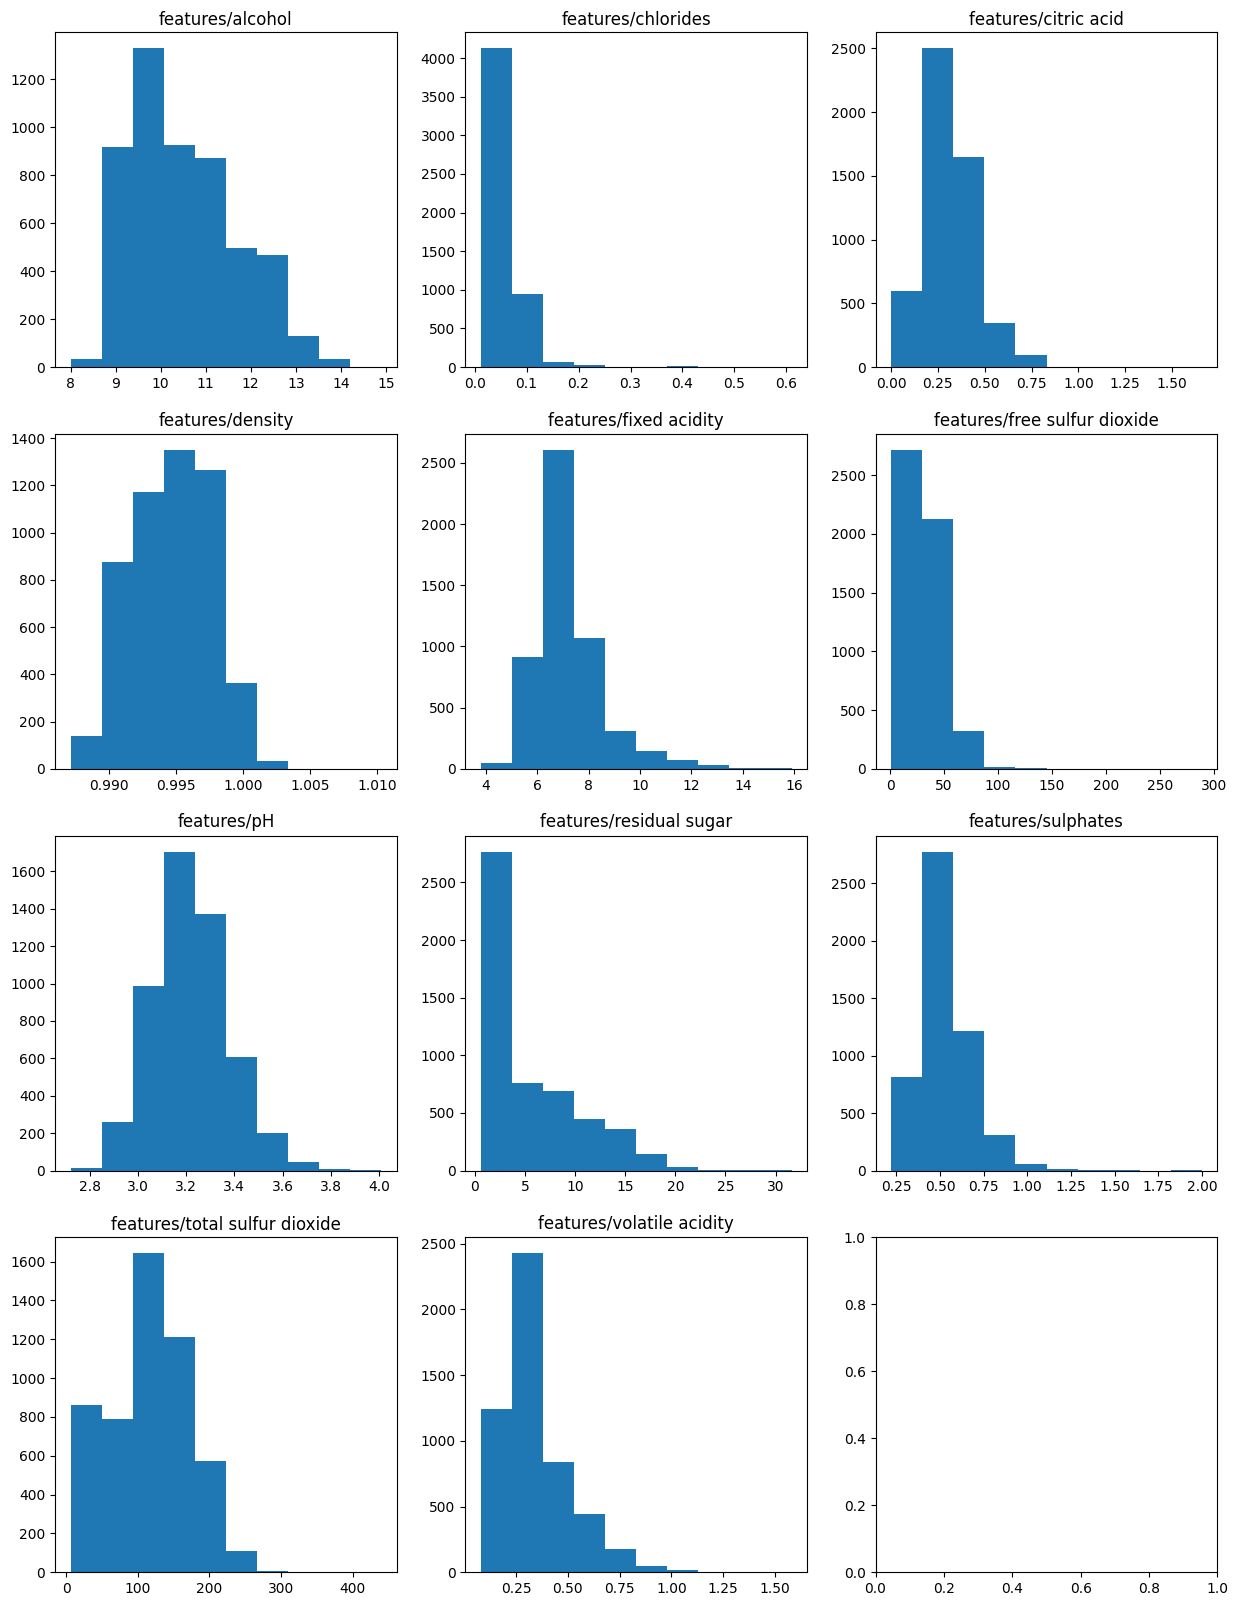

In [12]:
#visualizing the input features
nFeatures = len(df.columns)
nCols = 3
nRows = int(np.ceil(nFeatures/nCols))
cols = df.columns
fig, axs = plt.subplots(nRows,nCols,figsize=(15,20))#making a grid of plots
# for i, ax in enumerate(axs)
col = 0
for i in range(nRows):
    for j in range(nCols):
        if col >= nFeatures:
            break
        h = axs[i,j].hist(df[cols[col]])
        h = axs[i,j].set_title(cols[col])
        col += 1


print("\n *thumbs up*")

There seems to be a good spread of wines for each factor, so it might be a challenge to anneal to a certain value in each case, but we'll see what the network can do!!


 *thumbs up*


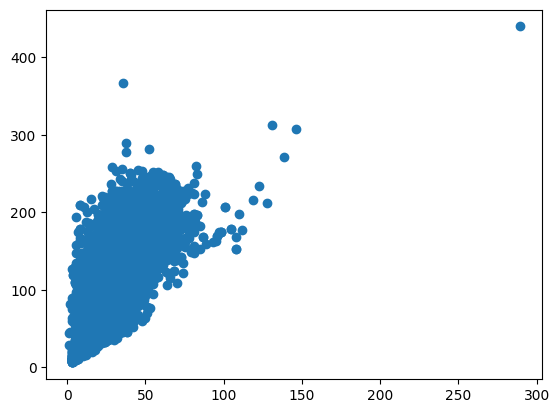

In [13]:
plt.scatter(df['features/free sulfur dioxide'],df['features/total sulfur dioxide'])

print("\n *thumbs up*")

There seems to be a correlation between these features. It might be pertinent to remove one of them in place of a function, but since there is a relatively small amount of training to do, it shouldn't be an issue here.

In a bigger network, it would be useful to reduce and curate the data as much as possible to reduce training time, but I won't do that here.

# Building the network
Build a simple DNN to perform a categorization (quality values). Relatively simple: a few hidden layers with a handful of neurons. If needed, we can increase the complexity to try and increase accuracy.

(From my testing, it seems that adding more nuerons makes an epoch take longer, but generally seems to make the accuracy go up more with each epoch. Quallitatively, I'd say it's most efficient to have many layers of a few neurons with 100 epochs.)


In [14]:
#Cell order: 6
try:
  if(cell_tracker[5]==6):
    cell_tracker[6]=7
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

cols = df.columns
nClasses = len(labels[0])

#using Keras's Sequential model - https://keras.io/api/models/sequential/
model = Sequential()
#add input layer
model.add(Input(shape=(len(cols),))) #the input layer shape should match the number of features

#add first layer of fully connected neurons
model.add(Dense(64,activation='relu'))

#add second layer (first hidden layer)
model.add(Dense(32,activation='relu'))

#...wanna add some more????
#model.add(Dense(64,activation='relu'))

#Create the output layer, only one neuron
#Here though, use the softmax activation function to make it a probability
model.add(Dense(nClasses,activation='softmax'))

#Compile the model
#And set the loss metric (categorical cross entropy)
#And the optimizer (stochastic gradient descent)
#If needed, you can use other optimizers as well
model.compile(loss='CategoricalCrossentropy',optimizer='Adam',metrics=['accuracy'])

#Get a summary
model.summary()

print("\n *thumbs up*")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,079 (12.03 KB)

 Trainable params: 3,079 (12.03 KB)

 Non-trainable params: 0 (0.00 B)


 *thumbs up*


## The same model can be built using the generic Model class and slightly different syntax
`
inputs = tf.keras.Input(shape=(len(cols),))
outputs_L1 = Dense(64, activation='relu')(inputs)
outputs_L2 = Dense(64, activation='relu')(outputs_L1)
outputs_L3 = Dense(64, activation='relu')(outputs_L2)
pred = Dense(1)(outputs_L3)
model = Model(inputs=inputs,outputs=pred)
`

# Training the model

Give the model all the input features (df) and the corresponding labels (labels). Keep 20% for validation (don't train on these).

Train for 100 epochs, passing the entire dataset through the network 100 times. Batch size is 20, meaning that 20 samples at a time are passed to the network before the parameters are updated. The `shuffle` argument shuffles the data before each epoch to reduce spurious learned correlations.

(Allowing it to run for 1000 epochs gave an average accuracy of about 65% near the end, capping at 70%, and it only seemed to increase with more epochs. Increasing the validation split and reducing the number of layers gives poor results (~70) even after allowing it to run for 5000 epochs. It is possible that adding more neurons per layer could increase the accuracy, but I have not found a maximum that optimizes training time.)



In [15]:
#This cell might take a while... 10 mins?
#I'll save the result to a file so we can just load it later
#If you wanna do that, just skip this cell, assuming you already ran it once
#Cell order: 7
try:
  if(cell_tracker[6]==7):
    cell_tracker[7]=8
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

history = model.fit(
    df, labels,
    validation_split=0.2,
    verbose=1, epochs=1000, batch_size=50, shuffle=True)


import pickle
#with open("Model_test.pickle", "wb") as fp:
#  pickle.dump(history, fp, pickle.HIGHEST_PROTOCOL)

#save the trained model in google drive
with open('/content/gdrive/My Drive/Gradient Descent Wine Tasting/Model_test.pickle', "wb") as fp:
  pickle.dump(history, fp, pickle.HIGHEST_PROTOCOL)

print("\n *thumbs up*")

Epoch 1/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2465 - loss: 6.7654 - val_accuracy: 0.3404 - val_loss: 1.5112
Epoch 2/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3971 - loss: 1.4463 - val_accuracy: 0.4317 - val_loss: 1.3656
Epoch 3/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4508 - loss: 1.3008 - val_accuracy: 0.4500 - val_loss: 1.2826
Epoch 4/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4582 - loss: 1.2749 - val_accuracy: 0.4471 - val_loss: 1.2471
Epoch 5/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4423 - loss: 1.2678 - val_accuracy: 0.4125 - val_loss: 1.3036
Epoch 6/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4500 - loss: 1.2518 - val_accuracy: 0.4538 - val_loss: 1.2229
Epoch 7/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4593 - loss: 1.2243 - val_accuracy: 0.4740 - val_loss: 1.2093
Epoch 8/1000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4808 - loss: 1.2045 - val_accuracy: 

KeyboardInterrupt: 

Visualize the loss


 *thumbs up*


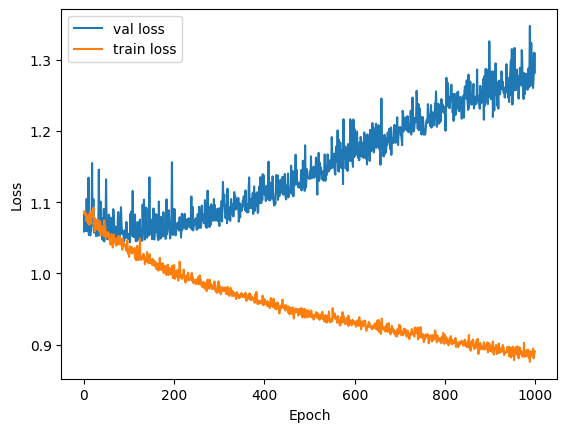

In [16]:
import pickle
#load the trained model in google drive
with open('/content/gdrive/My Drive/Gradient Descent Wine Tasting/Model_test.pickle', "rb") as inp:
  history = pickle.load(inp)


def show_loss(history):
    plt.figure()
    plt.plot(history.history['val_loss'], label="val loss")
    plt.plot(history.history['loss'],label="train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
show_loss(history)


print("\n *thumbs up*")

This shows that loss is monotonically minimized with each epoch (with some fluctuations) while the validation loss is higher on average.

The validation loss spikes more severely than the training loss, which is probably due to limited statistics (only had ~6k samples, with 20% being used for validation). The trend discrepancy between training and validation losses could indicate some overfitting in the model.

# Use test data to test the model's performance

In [17]:
#Cell order: 8
try:
  if(cell_tracker[7]==8):
    cell_tracker[8]=9
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

_, acc = model.evaluate(df_test, df_testLabels, verbose=1)
print('Accuracy for test data is',acc)

print("\n *thumbs up*")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5016 - loss: 1.1209 
Accuracy for test data is 0.5099999904632568

 *thumbs up*


For plotting the results, choose the highest probability of the classes and then get back a single number for that class.

To plot our results, I just chose the highest probability of the classes and assigned the prediction to a class based on that rounding (highest probability gets a 1, every other class gets a 0). Then, I one-hot decoded the rounded array to get a single number for the class.

(1300, 11)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[3.02899047e-04 3.27927968e-03 7.32444823e-02 ... 4.07690018e-01
  4.54446338e-02 8.98930244e-03]
 [1.32184883e-03 2.82475390e-02 2.97189325e-01 ... 2.37147912e-01
  3.06109022e-02 1.02139296e-04]
 [1.84633827e-05 3.98863282e-04 1.31668337e-02 ... 6.63947880e-01
  7.47773722e-02 8.67152005e-04]
 ...
 [3.63011000e-04 4.37782798e-03 1.85916021e-01 ... 1.40269563e-01
  4.54661362e-02 8.45797767e-04]
 [1.90780775e-04 9.70337354e-03 1.83207989e-01 ... 3.60466480e-01
  7.03631118e-02 3.97701864e-04]
 [1.09056302e-03 2.29595844e-02 2.63568759e-01 ... 2.25766256e-01
  4.33327407e-02 9.99623677e-04]]
[[3.02899047e-04 3.27927968e-03 7.32444823e-02 ... 4.07690018e-01
  4.54446338e-02 8.98930244e-03]
 [1.32184883e-03 2.82475390e-02 2.97189325e-01 ... 2.37147912e-01
  3.06109022e-02 1.02139296e-04]
 [1.84633827e-05 3.98863282e-04 1.31668337e-02 ... 6.63947880e-01
  7.47773722e-02 8.67152005e-04]
 ...
 [3.63011000e-04 4.37782798e-03 1.85916021e-01 

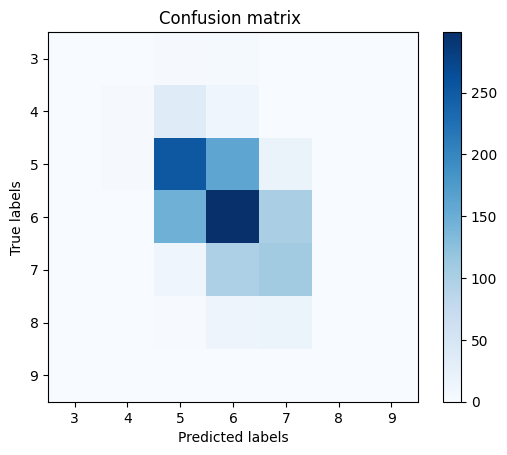


 *thumbs up*


In [43]:
#Cell order: 8
try:
  if(cell_tracker[7]==8):
    cell_tracker[8]=9
except:
  print("Run previous cells in order to fix this bug")
  ruisdfitw=r9ew8ygif

#print(np.shape(df_test))
#print(df_test)

preds = model.predict(df_test)
#print(preds)
#preds = [i.round() for i in preds]
#preds = [np.max(i) for i in preds]
#The output probabilities are so low that there is clearly no confidence, but I will
#use them anyway as a 1/1 probability:

#preds = [max_prob if x == max_prob else np.zeroes(np.shape(x)) for x in preds]

#preds = np.argmax(preds, axis=0)

#print(preds)
#print(preds[0])
preds = enc.inverse_transform(preds)
testLabels = enc.inverse_transform(df_testLabels)
cm = confusion_matrix(testLabels, preds)

_ =plt.imshow(cm, cmap=plt.cm.Blues)
_ = plt.xlabel("Predicted labels")
_ = plt.ylabel("True labels")

_ =plt.xticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.yticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.title('Confusion matrix ')
_ =plt.colorbar()
plt.show()

print("\n *thumbs up*")

It looks like the network found that 5,6,7 are the most common, so it's not likely to predict <4 or >7, interesting.


 *thumbs up*


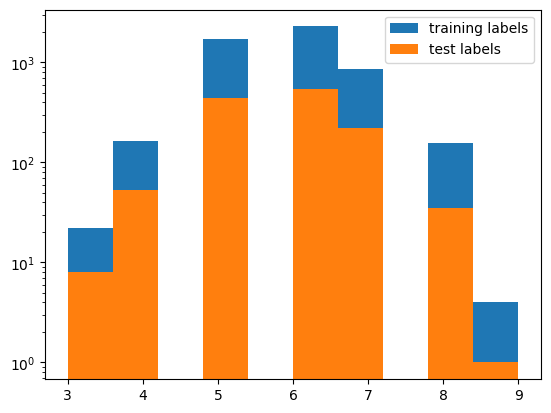

In [44]:
_=plt.hist(enc.inverse_transform(labels),label='training labels')
_=plt.hist(testLabels,label='test labels')
_=plt.yscale('log')
_=plt.legend()

print("\n *thumbs up*")

See here, the data is mostly middle-of-the-road wines. To better fit it to higher quality wines, we would need more or a different training method. Bootstrapping might be useful here as well.

# In Summary,
The network performs quite well, and does successfully make predictions that align with expectations. With more wines at higher/lower quality, better curation, and more training, it is likely that this could be a highly accurate predictor of wine quality.